<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/SAE_birds_left_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Step 1: Preprocess images, extract or load activations

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        print(f"Initializing dataset with {len(image_paths)} images")
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        print(f"Loading image: {image_path}")
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

def load_model(model_path):
    print(f"Loading model from {model_path}")
    model = models.alexnet(weights=None)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model



preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            # Append each activation separately instead of batch-wise
            for single_activation in tensor.cpu().numpy():
                activations.append(single_activation)

    print(f"Extracted activations for {len(activations)} images")
    return activations


def process_images_in_folder(model, folder_path, layer, batch_size=1):  # Set batch_size=1 to avoid batch aggregation
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations



def flatten_and_align_activations(activations_list):
    print("Flattening and aligning activations")
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    print(f"Aligned activations to shape: {np.vstack(aligned_activations).shape}")
    return np.vstack(aligned_activations)

def save_activations(activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{folder_name}/{filename}.npy'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    print(f"Saving activations to {drive_path}")
    np.save(drive_path, activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{folder_name}/{filename}.npy'
    print(f"Loading activations from {drive_path}")
    return np.load(drive_path, allow_pickle=True)

def compute_activations_for_layers(model_paths, folder_paths, layers, activations_file_prefix):
    # Initialize the dictionary with all keys in folder_paths
    all_layer_activations = {layer: {key: [] for key in folder_paths.keys()} for layer in layers}

    for model_idx, model_path in enumerate(model_paths):
        print(f"Processing model {model_idx + 1}/{len(model_paths)}")
        model = load_model(model_path)

        for folder_name, folder_path in folder_paths.items():  # e.g., 'wb_patch', 'wb_no_patch', 'lb_patch', etc.
            print(f"Processing folder {folder_name}")

            for layer in layers:
                # Define the activation path based on the model, layer, and folder (e.g., 'wb_patch' or 'wb_no_patch')
                activation_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_{model_idx}/layer_{layer}/{activations_file_prefix}_{folder_name}.npy'

                if os.path.exists(activation_path):
                    print(f"Activations for model {model_idx}, layer {layer}, folder {folder_name} already exist. Loading from file.")
                    activations = load_activations(f'model_{model_idx}/layer_{layer}', f'{activations_file_prefix}_{folder_name}')

                    # Check if loaded activations are empty
                    if activations.size == 0:
                        print(f"Warning: Loaded activations for model {model_idx}, layer {layer}, folder {folder_name} are empty!")
                    else:
                        print(f"Loaded activations shape: {activations.shape}")
                else:
                    # Compute activations if not already saved
                    print(f"Computing activations for model {model_idx}, layer {layer}, folder {folder_name}.")
                    activations = process_images_in_folder(model, folder_path, layer)
                    activations = flatten_and_align_activations(activations)
                    save_activations(activations, f'model_{model_idx}/layer_{layer}', f'{activations_file_prefix}_{folder_name}')

                # Save activations under the correct folder name for the corresponding layer
                all_layer_activations[layer][folder_name].append(activations)

        # Free resources
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations




# Step 2: Extract Training Activations

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt",
    #"/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_11train.pt",
    #"/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_111train.pt"
]

layers_of_interest = [17]

# Paths to training data
folder_paths = {
    'wb_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/wb_no_patch',
    'lb_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_no_patch',
    'lb_patch': '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_patch'
}

# Extract and save training activations
train_activations = compute_activations_for_layers(model_paths, folder_paths, layers_of_interest, 'train')


Processing model 1/1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt


<ipython-input-3-ebf03b9c4033>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully
Processing folder wb_no_patch
Activations for model 0, layer 17, folder wb_no_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_17/train_wb_no_patch.npy
Loaded activations shape: (2363, 4096)
Processing folder lb_no_patch
Activations for model 0, layer 17, folder lb_no_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_17/train_lb_no_patch.npy
Loaded activations shape: (1182, 4096)
Processing folder lb_patch
Activations for model 0, layer 17, folder lb_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_17/train_lb_patch.npy
Loaded activations shape: (1180, 4096)



Training autoencoder for layer 17
Combined activations shape for layer 17: (4725, 4096)
Number of combined activations (samples): 4725
Setting encoding dimension (h_dim) as: 8192
Training autoencoder for layer 17
Training autoencoder with input dim 4096 and encoding dim 8192
Epoch 1/100, Train Loss: 41.27185872395833, Val Loss: 44.391849517822266
Epoch 2/100, Train Loss: 33.20775941212972, Val Loss: 41.7978777885437
Epoch 3/100, Train Loss: 32.88131510416667, Val Loss: 41.65504598617554
Epoch 4/100, Train Loss: 32.805402692159014, Val Loss: 41.579965114593506
Epoch 5/100, Train Loss: 32.80987071990967, Val Loss: 41.53230905532837
Epoch 6/100, Train Loss: 32.776416842142744, Val Loss: 41.49859428405762
Epoch 7/100, Train Loss: 32.74938570658366, Val Loss: 41.470722675323486
Epoch 8/100, Train Loss: 32.74451192220052, Val Loss: 41.449681758880615
Epoch 9/100, Train Loss: 32.73828996022542, Val Loss: 41.43304967880249
Epoch 10/100, Train Loss: 32.74256057739258, Val Loss: 41.415094375610

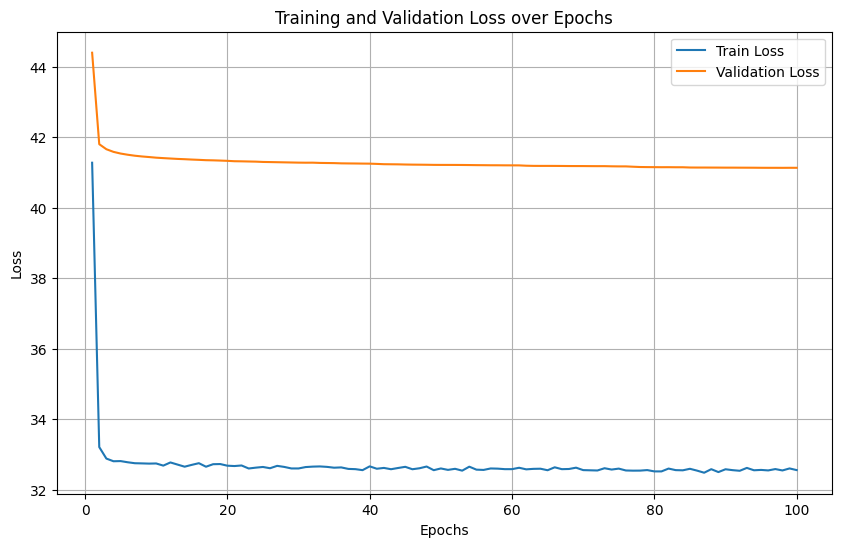

Autoencoder for layer 17 saved at /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/Autoencoders/autoencoder_layer_17.pth

All autoencoders trained and saved successfully.


In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import gc

# Step 3: Define Sparse Autoencoder with KL-divergence
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.05, xavier_norm_init=True):
        super(SparseAutoencoder, self).__init__()
        self.in_dims = in_dims  # Input dimension (number of neurons in the input layer)
        self.h_dims = h_dims  # Hidden dimension (number of neurons in the hidden layer)
        self.sparsity_lambda = sparsity_lambda  # Weight for the sparsity penalty term
        self.sparsity_target = sparsity_target  # Target sparsity (desired average activation)

        # Encoder: Projects input to the hidden (sparse) space
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dims, self.h_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)  # Xavier initialization

        # Decoder: Reconstructs the input from the hidden (sparse) representation
        self.decoder = nn.Sequential(
            nn.Linear(self.h_dims, self.in_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)

    # Forward pass through the encoder and decoder
    def forward(self, x):
        encoded = self.encoder(x)  # Pass input through encoder
        decoded = self.decoder(encoded)  # Pass encoded (sparse) representation through decoder
        return encoded, decoded

    # KL-divergence sparsity penalty calculation
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)  # Compute the average activation for each hidden neuron
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)
        kl_divergence = F.kl_div((rho_hat + epsilon).log(), rho + epsilon, reduction='batchmean')  # KL-divergence
        return self.sparsity_lambda * kl_divergence  # Return the sparsity penalty, weighted by lambda

    # Loss function combining MSE (reconstruction error) and sparsity penalty
    def loss_function(self, decoded, original, encoded):
        mse_loss = F.mse_loss(decoded, original)  # Mean Squared Error for reconstruction
        sparsity_loss = self.sparsity_penalty(encoded)  # Sparsity penalty for hidden layer activations
        return mse_loss + sparsity_loss  # Total loss is MSE + sparsity penalty


# Early stopping mechanism to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.best_loss = None  # Best validation loss observed so far
        self.counter = 0  # Counter to keep track of how many epochs since the last improvement

    # Check if training should be stopped based on validation loss
    def check(self, loss):
        if self.best_loss is None:
            self.best_loss = loss  # Set the initial best loss
            return False

        # If the loss has improved significantly
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss  # Update best loss
            self.counter = 0  # Reset counter
            return False
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                print("Early stopping triggered.")  # Stop training if patience is exceeded
                return True
        return False


# Training Function with Loss Tracking and Plotting
def train_autoencoder(autoencoder, data, num_epochs=100, batch_size=128, learning_rate=1e-5, validation_split=0.2, clip_gradients=True, max_grad_norm=0.5):
    print(f"Training autoencoder with input dim {data.shape[1]} and encoding dim {autoencoder.h_dims}")

    # Split the data into training and validation sets
    num_train = int((1 - validation_split) * len(data))  # Compute the number of training samples
    train_data = data[:num_train]  # Training data
    val_data = data[num_train:]  # Validation data

    # Create PyTorch datasets and dataloaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float())
    val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_data).float())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Adam optimizer with learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-2)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    # Lists to store training and validation loss values
    train_losses = []
    val_losses = []

    # Start training loop
    autoencoder.train()  # Set the autoencoder in training mode
    for epoch in range(num_epochs):
        total_train_loss = 0  # Initialize training loss for the current epoch

        # Iterate over batches in the training set
        for x_batch, in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()  # Zero the gradients
            encoded, decoded = autoencoder(x_batch)  # Forward pass through autoencoder
            loss = autoencoder.loss_function(decoded, x_batch, encoded)  # Compute the loss
            loss.backward()  # Backpropagate the error

            # Apply gradient clipping if enabled
            if clip_gradients:
                torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_grad_norm)

            optimizer.step()  # Update the weights using the optimizer
            total_train_loss += loss.item()  # Accumulate training loss for this batch

        # Validation step after each epoch
        total_val_loss = 0  # Initialize validation loss
        autoencoder.eval()  # Set the autoencoder in evaluation mode
        with torch.no_grad():  # No gradient calculation in validation mode
            for x_batch, in val_loader:
                x_batch = x_batch.to(device)
                encoded, decoded = autoencoder(x_batch)
                loss = autoencoder.loss_function(decoded, x_batch, encoded)
                total_val_loss += loss.item()

        # Compute the average training and validation loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Store the loss values for plotting later
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress for the current epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

        # Check early stopping condition based on validation loss
        if early_stopping.check(avg_val_loss):
            break

    print("Autoencoder training completed")

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return autoencoder


# Paths and Layers Definition
save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/Autoencoders/'  # Directory to save the trained autoencoder
os.makedirs(save_sae_dir, exist_ok=True)

layers_of_interest = [17]  # Define which layers' activations to train autoencoders on, currently only on the FC2 (17)


# Step 4: Train Sparse Autoencoders for each layer by combining activations
for layer in layers_of_interest:
    print(f'\nTraining autoencoder for layer {layer}')

    if layer in train_activations:
        # Combine activations from all subsets ('wb_no_patch', 'lb_no_patch', 'lb_patch')
        activations_list = []
        for subset in ['wb_no_patch', 'lb_no_patch', 'lb_patch']:
            if subset in train_activations[layer]:
                activations_list += train_activations[layer][subset]  # Append all activations

        if len(activations_list) == 0:
            print(f"No activations found for layer {layer}. Skipping...")
            continue

        # Concatenate all activations for this layer into a single array
        combined_activations = np.vstack(activations_list)
        print(f"Combined activations shape for layer {layer}: {combined_activations.shape}")

        # Print the number of combined activations (i.e., number of samples)
        num_combined_activations = combined_activations.shape[0]
        print(f"Number of combined activations (samples): {num_combined_activations}")

        # Set the encoding dimension (hidden layer size) as 2 times the number of combined activations
        encoding_dim = min(num_combined_activations * 2, 8192)  # Cap the encoding dim at 8192 (twice the nunber of combined activations for later experimentations)
        print(f"Setting encoding dimension (h_dim) as: {encoding_dim}")

        # Input dimension is the number of neurons in the original input layer
        input_dim = combined_activations.shape[1]

        # Initialize the autoencoder with the specified input and hidden dimensions
        autoencoder = SparseAutoencoder(input_dim, encoding_dim).to(device)

        # Train the autoencoder on the combined activations
        print(f"Training autoencoder for layer {layer}")
        autoencoder = train_autoencoder(
            autoencoder,
            combined_activations,  # unnormalized activations
            num_epochs=100,
            learning_rate=1e-5
        )

        # Save the trained autoencoder
        save_path = os.path.join(save_sae_dir, f'autoencoder_layer_{layer}.pth')
        torch.save(autoencoder.state_dict(), save_path)
        print(f"Autoencoder for layer {layer} saved at {save_path}")

        # Clear memory after saving
        del combined_activations, autoencoder
        gc.collect()
        torch.cuda.empty_cache()
    else:
        print(f"Layer '{layer}' not found in train_activations. Skipping...")

print("\nAll autoencoders trained and saved successfully.")


Define Sparse Autoencoder

Loading model from /content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt


<ipython-input-3-ebf03b9c4033>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully

--- Processing layer 17 ---
Loading autoencoder for layer 17 from /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/Autoencoders/autoencoder_layer_17.pth with input dimension 4096


<ipython-input-36-6edd50993be0>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_path))


Autoencoder for layer 17 loaded successfully.
Initializing dataset with 300 images
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Herring_Gull_0145_46220.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Hooded_Merganser_0002_796781.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Hooded_Merganser_0006_796778.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Hooded_Merganser_0007_79157.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Hooded_Merganser_0009_79012.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Hooded_Merganser_0012_796748.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch/Hooded_Merganser_0011_796750.jpg
Loading image: /content/drive/MyDrive/Masterthesis/Datas

<ipython-input-36-6edd50993be0>:131: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


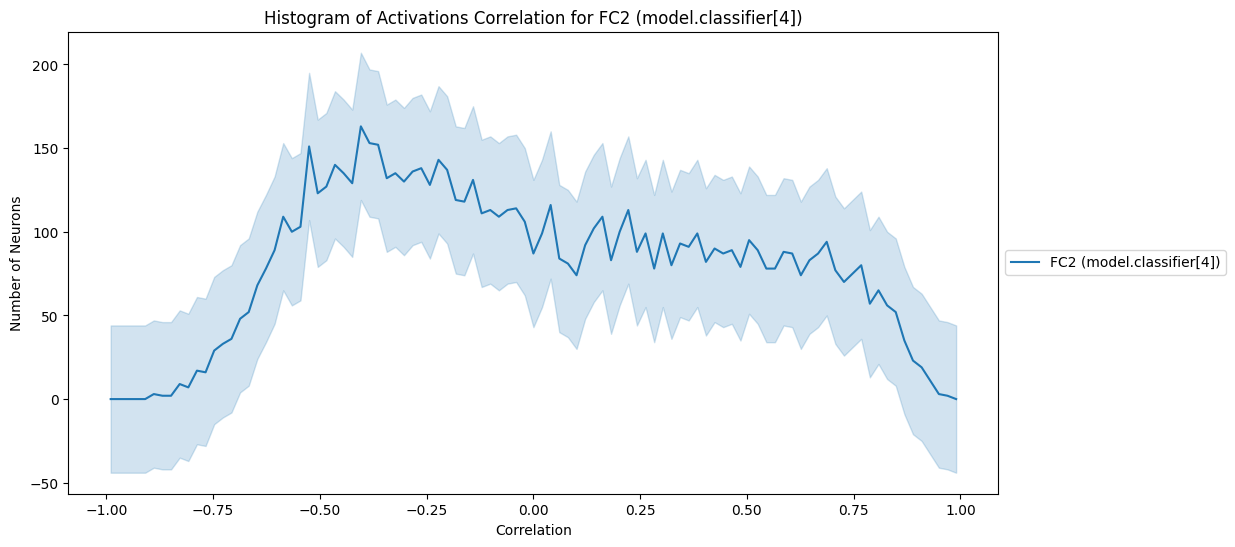

<ipython-input-36-6edd50993be0>:179: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


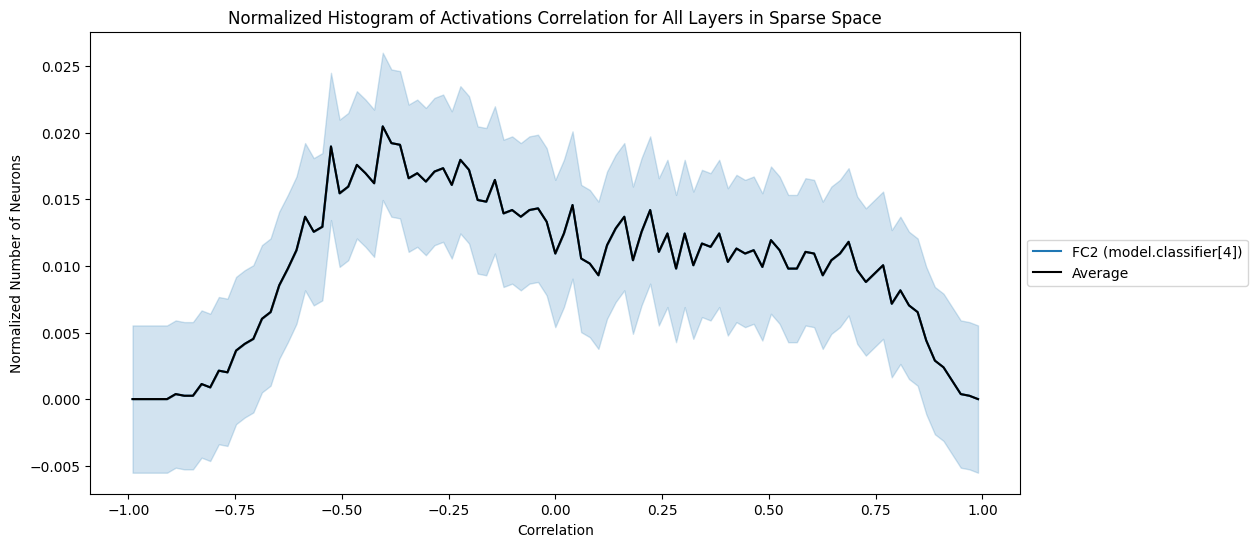

In [36]:
# With Normalization
import torch
import numpy as np
import os
import gc
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load Autoencoders
def load_autoencoder(layer, encoding_dim, device):
    save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/Autoencoders/'
    save_path = os.path.join(save_sae_dir, f'autoencoder_layer_{layer}.pth')

    # Set the input dimension based on the layer
    layer_input_dims = {
        0: 193600,
        3: 139968,
        6: 64896,
        8: 43264,
        10: 43264,
        14: 4096,
        17: 4096
    }

    if layer not in layer_input_dims:
        print(f"Input dimension for layer {layer} not found. Skipping.")
        return None

    input_dim = layer_input_dims[layer]  # Use the correct input dimension for the layer
    print(f"Loading autoencoder for layer {layer} from {save_path} with input dimension {input_dim}")

    autoencoder = SparseAutoencoder(input_dim, encoding_dim).to(device)

    try:
        autoencoder.load_state_dict(torch.load(save_path))
        autoencoder.eval()
        print(f"Autoencoder for layer {layer} loaded successfully.")
    except Exception as e:
        print(f"Error loading autoencoder for layer {layer}: {e}")
        return None

    return autoencoder
'''
# Normalize activations
def normalize_activations(activations):
    activations -= np.mean(activations, axis=0)
    std = np.std(activations, axis=0)
    std[std == 0] = 1  # Prevent division by zero
    activations /= std
    return activations
'''
# Function to project activations into sparse space
def project_activations(autoencoder, activations, device):
    print(f"Projecting activations. Shape before projection: {activations.shape}")

    try:
        with torch.no_grad():
            # Use activations directly without normalization
            projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
        print(f"Projection successful. Shape after projection: {projected.shape}")
    except Exception as e:
        print(f"Error during projection: {e}")
        return None

    return projected.cpu().numpy()


# Step 1: Extract test activations from test folders (with and without patch)
def process_images_in_folder(model, folder_path, layer, batch_size=1):
    all_layer_activations = []
    image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(folder_path) for file in files if file.endswith(('.jpg', '.png'))]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return flatten_and_align_activations(all_layer_activations)

# Step 2: Extract and project activations into sparse space
def extract_and_project_test_activations(model, patch_folder, no_patch_folder, layers, device):
    projected_test_activations = {'wb_patch': {}, 'wb_no_patch': {}}

    for layer in layers:
        print(f'\n--- Processing layer {layer} ---')

        # Step 2.1: Load the autoencoder for the current layer
        autoencoder = load_autoencoder(layer, encoding_dim=8192, device=device)
        if autoencoder is None:
            print(f"Skipping layer {layer} due to autoencoder loading error.")
            continue

        # Step 2.2: Extract and project activations for the folder with patches
        try:
            activations_with_patch = process_images_in_folder(model, patch_folder, layer)
            print(f"Activations shape with patch (before projection): {activations_with_patch.shape}")
            projected_test_activations['wb_patch'][layer] = project_activations(autoencoder, activations_with_patch, device)
        except Exception as e:
            print(f"Error projecting 'wb_patch' activations for layer {layer}: {e}")
            continue

        # Step 2.3: Extract and project activations for the folder without patches
        try:
            activations_without_patch = process_images_in_folder(model, no_patch_folder, layer)
            print(f"Activations shape without patch (before projection): {activations_without_patch.shape}")
            projected_test_activations['wb_no_patch'][layer] = project_activations(autoencoder, activations_without_patch, device)
        except Exception as e:
            print(f"Error projecting 'wb_no_patch' activations for layer {layer}: {e}")
            continue

        print(f"Projection completed for layer {layer}.")
        del autoencoder
        torch.cuda.empty_cache()

    return projected_test_activations

# Step 3: Perform Correlation Analysis
def plot_histogram_for_layer(layer, layer_name, activations_with_patch, activations_without_patch, color):
    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(activations_without_patch)), np.ones(len(activations_with_patch))])
    combined_activations = np.vstack((activations_without_patch, activations_with_patch))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

# Perform correlation analysis for each layer
def perform_correlation_analysis(projected_test_activations, layers_of_interest, layer_names, colors):
    for idx, layer in enumerate(layers_of_interest):
        plot_histogram_for_layer(
            layer,
            layer_names[layer],  # Use layer_names dictionary to get the name of the layer
            projected_test_activations['wb_patch'][layer],
            projected_test_activations['wb_no_patch'][layer],
            colors[idx]
        )

# Combined plot for all layers
def plot_combined_histogram(layer_names, colors, projected_test_activations, layers_of_interest):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, layer in enumerate(layers_of_interest):
        activations_with_patch = projected_test_activations['wb_patch'][layer]
        activations_without_patch = projected_test_activations['wb_no_patch'][layer]

        patch_no_patch = np.hstack([np.zeros(len(activations_without_patch)), np.ones(len(activations_with_patch))])
        combined_activations = np.vstack((activations_without_patch, activations_with_patch))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0]) if np.sum(B[0]) != 0 else np.zeros_like(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_names[layer])
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers in Sparse Space')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main Execution

# Paths to test folders
patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch'
no_patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_no_patch'

# Load the model (first AlexNet model)
model_path = "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt"
model = load_model(model_path)

# Define layers of interest
layers_of_interest = [17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

# Extract and project test activations
projected_test_activations = extract_and_project_test_activations(model, patch_folder, no_patch_folder, layers_of_interest, device)

# Perform correlation analysis
perform_correlation_analysis(projected_test_activations, layers_of_interest, layer_names, colors)

# Combined histogram plot
plot_combined_histogram(layer_names, colors, projected_test_activations, layers_of_interest)


In [ ]:
activations1 = np.load('/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/activations.npy', allow_pickle=True) # Set allow_pickle=True to load object arrays
activations2 = np.load('/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_0/train_wb_no_patch.npy')
print(f"Shape of activations1: {activations1.shape}")
print(f"Shape of activations2: {activations2.shape}")

In [ ]:
# Check activations for a specific layer if activations is a dictionary
layer_0_activations = activations['layer_0']
print(f"Layer 0 activations shape: {layer_0_activations.shape}")
print(f"Layer 0 sample activations: {layer_0_activations[:2]}")


In [ ]:
import os
file_size = os.path.getsize(file_path)
print(f"File size of activations.npy: {file_size} bytes")
